In [1]:
#!pip install tf-nightly-gpu
#!pip install "tensorflow_hub==0.4.0"
#!pip install tensorflow

ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu (from versions: none)
ERROR: No matching distribution found for tf-nightly-gpu


In [2]:
# standart ds libs
import random
import numpy as np 
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import PIL
import re
import json
from pandas.io.json import json_normalize
import pickle

# plt
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab 
#change deff size
from pylab import rcParams
rcParams['figure.figsize'] = 25, 15
plt.rcParams["figure.figsize"] = (25,25)
#graps in svg
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)

import seaborn as sns
sns.set_theme(style="whitegrid")

In [3]:
image = PIL.Image

In [8]:
# ml libs
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow import keras

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [5]:
tf.executing_eagerly()

False

In [6]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Загружаем модель и веса

In [11]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_RES = 224

In [12]:
f_extractor = tf.keras.Sequential([
                             hub.KerasLayer(CLASSIFIER_URL, trainable=False, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])
f_extractor.trainable = False

In [13]:
model = tf.keras.Sequential([
  f_extractor,
  layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1001)              3540265   
_________________________________________________________________
dense (Dense)                (None, 3)                 3006      
Total params: 3,543,271
Trainable params: 3,006
Non-trainable params: 3,540,265
_________________________________________________________________


In [14]:
model.load_weights('my_model_weights.h5')

## Загружаем Тестовый датасет и делаем предсказание

In [17]:
DATA_DIR = 'Dataset/'
json_dir = DATA_DIR + 'data.json'

with open(json_dir) as json_data:
    data = json.load(json_data)

test = pd.DataFrame(data['test_bundle'])

In [83]:
target_class ={0:'other'
              ,1:'vehicles'
              ,2:'plants'}  
 
# ресайз и приведеине к ргб
def get_pic(row):
    return np.array(image.open(DATA_DIR + str(row['file'])).convert('RGB').resize((IMAGE_RES, IMAGE_RES)))
                   
# таргет класс
def get_lable(pic):
    predict =  model.predict(pic[np.newaxis, ...])
    return predict[0]

def get_max(preds, classes):
    m = 0
    for i in classes.keys():
        if preds[i] > preds[m]:
            m=i
    return preds[m],  classes[m]

# собираем Pics n predict 
def get_preds(df):
    preds = pd.DataFrame(columns =['pic_url','predict_class','confidence'])
    
    for index, row in df.iterrows():
        conf, pic_type = get_max(get_lable(get_pic(row)), target_class) 
        preds.loc[index] = [row['file'], pic_type, conf] 
        
    return preds


In [85]:
predicts = get_preds(test)

In [88]:
predicts.to_csv('predicted_classes.csv', sep=',')

## для тестов

вы можете выбрать любое изображение из контрольной группы, но для этого надо перезапустить весь Kernel

In [89]:
predicts = pd.read_csv('predicted_classes.csv', sep=',')

In [105]:
def pic_n_predict(url):
    sample = predicts[predicts.pic_url == url]
    im = PIL.Image.open(DATA_DIR + str(url))
    plt.imshow(im)
    plt.axis('off')
    _ = plt.title(f'''определенный класс-{sample['predict_class'].values}, степень уверенности-{sample['confidence'].values}''')

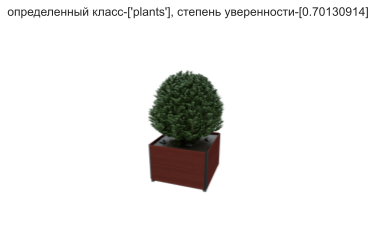

In [107]:
pic_n_predict('data/7e5ba16b-6223-41f3-8f64-07ea079ece48.png')

## Для тестов №2
или можете проверить любое другое изображение.
для этого: сохраните изображение в папку /Dataset/data
и введите его название(целиком) как аргумент в функцию any_pic_predict

In [110]:
def any_pic_predict(url):
    pic = np.array(image.open(DATA_DIR + str(url)).convert('RGB').resize((IMAGE_RES, IMAGE_RES)))
    conf, pic_type = get_max(get_lable(pic), target_class)
    im = PIL.Image.open(DATA_DIR + str(url))
    plt.imshow(im)
    plt.axis('off')
    _ = plt.title(f'''определенный класс-{pic_type}, степень уверенности-{conf}''')

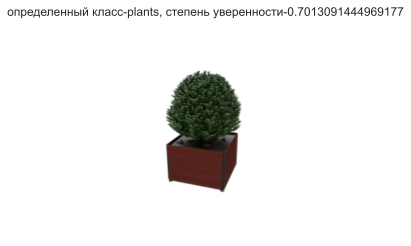

In [111]:
any_pic_predict('data/7e5ba16b-6223-41f3-8f64-07ea079ece48.png')